In [1]:
!pip install CBFV

     |████████████████████████████████| 539 kB 4.1 MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from CBFV.composition import generate_features


## Load the pre-processed dataset

We will start with the processed dataset that we saved from the last notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = os.getcwd()
data_path = os.path.join(PATH, '/content/drive/MyDrive/jupyter/2D/data/C2DB_gap.csv')
df = pd.read_csv(data_path)

df.head(10)

,Formula,Band gap
0,Ag2Au2Cl8,0.9090
1,Ag2Br2,1.7790
2,Ag2Br2S4,1.1670
3,Ag2Br2Se4,1.2370
4,Ag2Br2Te4,1.2140
5,Ag2Br6,0.0230
6,Ag2C8N6,3.4120
7,Ag2Cl2,1.7845
8,Ag2Cl2S4,1.1860
9,Ag2Cl2Se4,1.3400


## Generate features using the `CBFV` package

To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [`CBFV` package](https://github.com/kaaiian/CBFV).

The `generate_features` function from the CBFV package expects an input DataFrame containing at least the columns `['formula', 'target']`. You may also have extra feature columns (e.g., `temperature` or `pressure`, other measurement conditions, etc.).

Since the `generate_features` function expects the target variable column to be named `target`, we have to rename 


In [6]:
rename_dict = {'Formula': 'formula', 'Band gap': 'target'}
df = df.rename(columns=rename_dict)
df.head()

,formula,target
0,Ag2Au2Cl8,0.909
1,Ag2Br2,1.779
2,Ag2Br2S4,1.167
3,Ag2Br2Se4,1.237
4,Ag2Br2Te4,1.214


Now we can use the `generate_features` function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to `generate_features`:
* `elem_prop='oliynyk'`
* `drop_duplicates=False`
* `extend_features=True`
* `sum_feat=True`

A short explanation for the choice of keyword arguments is below:
* The `elem_prop` parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the `oliynyk` CBFV featurization scheme.
* The `drop_duplicates` parameter specifies whether to drop duplicate formulae during featurization.
* The `extend_features` parameter specifies whether to include extended features (features that are not part of `['formula', 'target']`) in the featurized data.
* The `sum_feat` parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (`True`).


In [7]:
from time import time

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

def plot_pred_act(f, act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{f}:{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

In [8]:
df_classics = pd.DataFrame(columns=['model_name',
                                  'model_name_pretty',
                                  'model_params',
                                  'fit_time',
                                  'r2_train',
                                  'mae_train',
                                  'rmse_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])
# df_classics

# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})

In [9]:
for f in ['jarvis', 'magpie', 'mat2vec', 'oliynyk', 'onehot','random_200']:
  X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df, elem_prop=f, drop_duplicates=False, extend_features=False, sum_feat=True)
  
  SEED = 42
  X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_train_unscaled, y_train, test_size=0.20, random_state=SEED)
  X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.30, random_state=SEED)
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train_unscaled)
  X_val = scaler.transform(X_val_unscaled)
  X_test = scaler.transform(X_test_unscaled)
  
  # Instantiate a dictionary to store the model objects
  classic_models = OrderedDict()

  # Keep track of elapsed time
  ti = time()

  # Loop through each model type, fit and predict, and evaluate and store results
  for model_name, model in classic_model_names.items():
      print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
      model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
      df_classics = append_result_df(df_classics, result_dict)
      classic_models = append_model_dict(classic_models, model_name, model)

  dt = time() - ti
  print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

  # Sort in order of increasing validation r2 score
  df_classics = df_classics.sort_values('r2_val', ignore_index=True)
  df_classics

  for row in range(df_classics.shape[0]):
      model_name = df_classics.iloc[row]['model_name']

      model = classic_models[model_name]
      y_act_val = y_val
      y_pred_val = model.predict(X_val)

      plot = plot_pred_act(f, y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{gap}}$ (ev)')

Output hidden; open in https://colab.research.google.com to view.

oliynyk:extratrees,r2 =~0.6839~ 0.6965


In [10]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df, elem_prop='oliynyk', drop_duplicates=False, extend_features=False, sum_feat=True)

Processing Input Data: 100%|██████████| 1214/1214 [00:00<00:00, 12152.50it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1214/1214 [00:00<00:00, 5695.70it/s]


	Creating Pandas Objects...


In [11]:
X_train_unscaled

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,388.0,893.29108,46.0,180.0,80.0,4.0,8.0,0.0,1014.0,12.0,...,2.2,172.15,238.55,0.00321,0.480,3.2300,10.200,0.0089,121.0,1.40
1,164.0,375.54440,18.0,56.0,24.0,2.0,2.0,0.0,320.0,2.0,...,3.1,265.95,331.95,3.12000,0.235,5.2860,15.438,0.1220,112.0,1.22
2,228.0,503.80840,30.0,120.0,52.0,2.0,6.0,0.0,672.0,6.0,...,2.9,385.95,717.85,2.07000,0.710,1.7175,9.800,0.2690,279.0,2.85
3,300.0,691.38440,34.0,120.0,52.0,2.0,6.0,0.0,676.0,6.0,...,3.8,490.15,958.15,4.79000,0.320,6.6940,37.700,0.5200,227.0,2.46
4,372.0,885.94440,38.0,120.0,48.0,2.0,6.0,0.0,680.0,6.0,...,5.5,722.65,1262.95,6.24000,0.200,17.4900,52.550,2.3500,197.0,2.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,90.0,202.25000,12.0,36.0,18.0,1.0,2.0,0.0,221.0,4.0,...,2.9,385.95,717.85,2.07000,0.270,1.7175,9.800,0.2690,227.0,2.46
1210,108.0,250.89000,13.0,36.0,17.0,1.0,2.0,0.0,222.0,4.0,...,2.9,385.95,717.85,2.07000,0.200,1.7175,9.800,0.2690,197.0,2.19
1211,108.0,249.14400,13.0,36.0,18.0,1.0,2.0,0.0,222.0,4.0,...,3.8,490.15,958.15,4.79000,0.320,6.6940,37.700,0.5200,227.0,2.46
1212,126.0,297.78400,14.0,36.0,17.0,1.0,2.0,0.0,223.0,4.0,...,3.8,490.15,958.15,4.79000,0.200,6.6940,37.700,0.5200,197.0,2.19


## Splitting data 
### Normally, we could simply split the data with a simple `sklearn` function

The scikit-learn `train_test_split` function randomly splits a dataset into train and test datasets.
Typically, you can use `train_test_split` to first split your data into "train" and "test" datasets, and then use the function again to split your "train" data into "train" and "validation" dataset splits.
As a rule of thumb, you can roughly aim for the following dataset proportions when splitting your data:

| | train split | validation split | test split |
| --- | --- | --- | --- |
| proportion<br> of original<br> dataset | 50% to 70% | 20% to 30% | 10% to 20% |

In [12]:
SEED = 42
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_train_unscaled, y_train, test_size=0.20, random_state=SEED)
X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.30, random_state=SEED)


## Data scaling & normalization

For numerical input data, scaling and normalization of the features often improves the model performance.
Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others).
This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn.

## Scaling the data

First, we instantiate the scaler object.

In a `StandardScaler` object:
* During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
* Then, during the `transform` process, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data.
For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should *only* `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# Modeling using "classical" machine learning models

Here we implement some classical ML models from `sklearn`:

* Ridge regression
* Support vector machine
* Linear support vector machine
* Random forest
* Extra trees
* Adaptive boosting
* Gradient boosting
* k-nearest neighbors
* Dummy (if you can't beat this, something is wrong.)

Note: the Dummy model types from `sklearn` act as a good sanity check for your ML studies. If your models do not perform significantly better than the equivalent Dummy models, then you should know that something has gone wrong in your model implementation.

In [14]:
from time import time

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In addition, we define some helper functions.

In [15]:
def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

Build an empty DataFrame to store model results:

In [16]:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val


In [17]:
# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})

## Instantiate and fit the models

Now, we can fit the ML models.

We will loop through each of the models listed above. For each of the models, we will:
* instantiate the model (with default parameters)
* fit the model using the training data
* use the fitted model to generate predictions from the validation data
* evaluate the performance of the model using the predictions
* store the results in a DataFrame for analysis

Note: this may take several minutes, depending on your hardware/software environment, dataset size and featurization scheme (CBFV).

In [18]:
# Instantiate a dictionary to store the model objects
classic_models = OrderedDict()

# Keep track of elapsed time
ti = time()

# Loop through each model type, fit and predict, and evaluate and store results
for model_name, model in classic_model_names.items():
    print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
    model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
    df_classics = append_result_df(df_classics, result_dict)
    classic_models = append_model_dict(classic_models, model_name, model)

dt = time() - ti
print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

Now fitting and evaluating model dumr: DummyRegressor
Now fitting and evaluating model rr: Ridge
Now fitting and evaluating model abr: AdaBoostRegressor
Now fitting and evaluating model gbr: GradientBoostingRegressor
Now fitting and evaluating model rfr: RandomForestRegressor
Now fitting and evaluating model etr: ExtraTreesRegressor
Now fitting and evaluating model svr: SVR
Now fitting and evaluating model lsvr: LinearSVR
Now fitting and evaluating model knr: KNeighborsRegressor
Finished fitting 9 models, total time: 14.90 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [19]:
# Sort in order of increasing validation r2 score
df_classics = df_classics.sort_values('r2_val', ignore_index=True)
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
0,dumr,DummyRegressor,"{'constant': None, 'quantile': None, 'strategy...",0.000583,0.000000,9.784004e-01,1.282355e+00,-0.000994,0.966147,1.265501
1,lsvr,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.476277,0.713926,4.557352e-01,6.858792e-01,0.340609,0.724173,1.027112
2,knr,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.000782,0.703735,4.852223e-01,6.979888e-01,0.457444,0.654524,0.931685
3,rr,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.011062,0.771027,4.661820e-01,6.136205e-01,0.496547,0.672257,0.897482
4,svr,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.070060,0.759373,3.887308e-01,6.290434e-01,0.547112,0.582241,0.851221
5,abr,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",1.082273,0.740320,5.590665e-01,6.534730e-01,0.554330,0.684968,0.844410
6,gbr,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",2.782790,0.933948,2.551669e-01,3.295724e-01,0.668646,0.520990,0.728103
7,rfr,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",6.785547,0.960663,1.787069e-01,2.543350e-01,0.672973,0.512623,0.723333
8,etr,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",3.327315,1.000000,1.432210e-15,2.386172e-15,0.702443,0.468871,0.689972


## Evaluating model performance on validation dataset

Now comes the time to evaluate the trained models on the validation set.

Remember, we use the same validation set to evaluate all models. This ensures a fair comparison.

In addition, we plot the predicted vs. actual plots using the predictions made by each trained model on the same validation set.

In [20]:
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

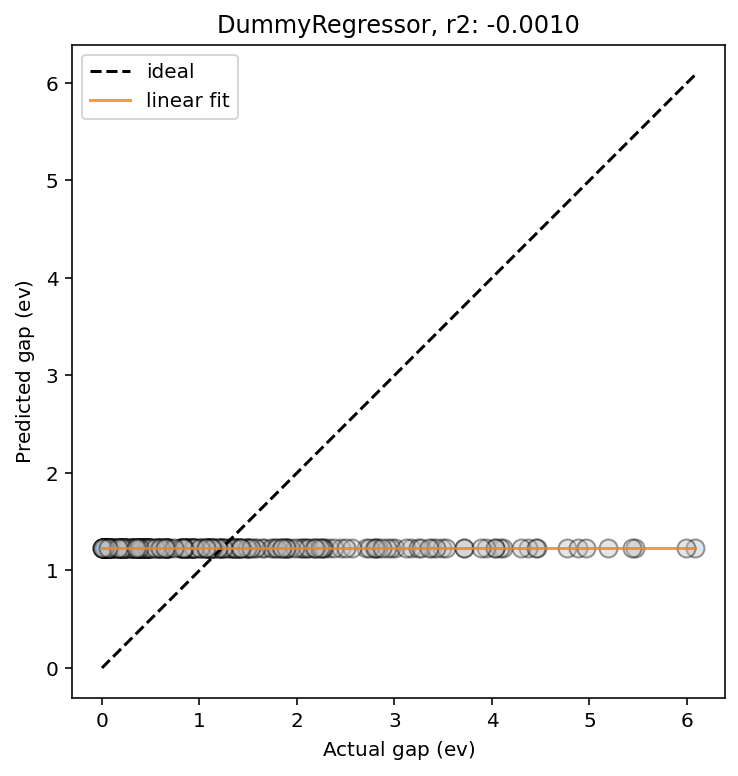

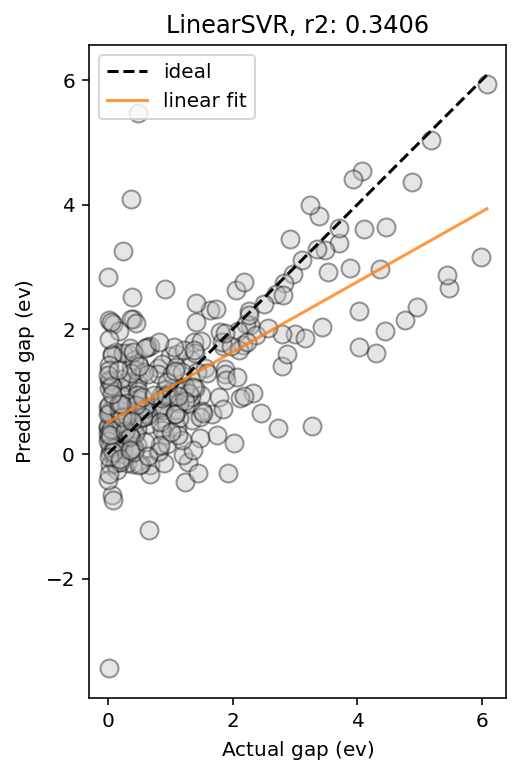

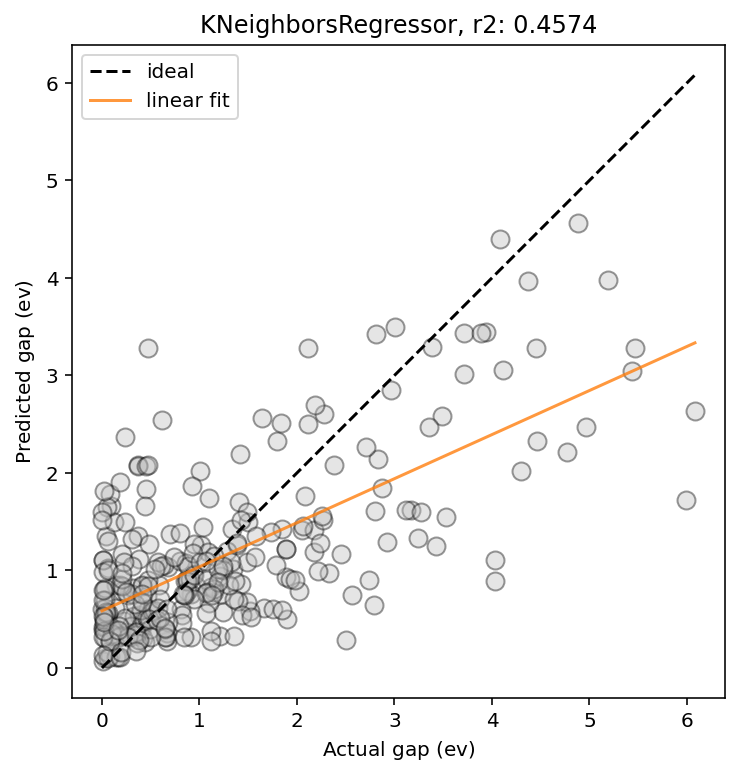

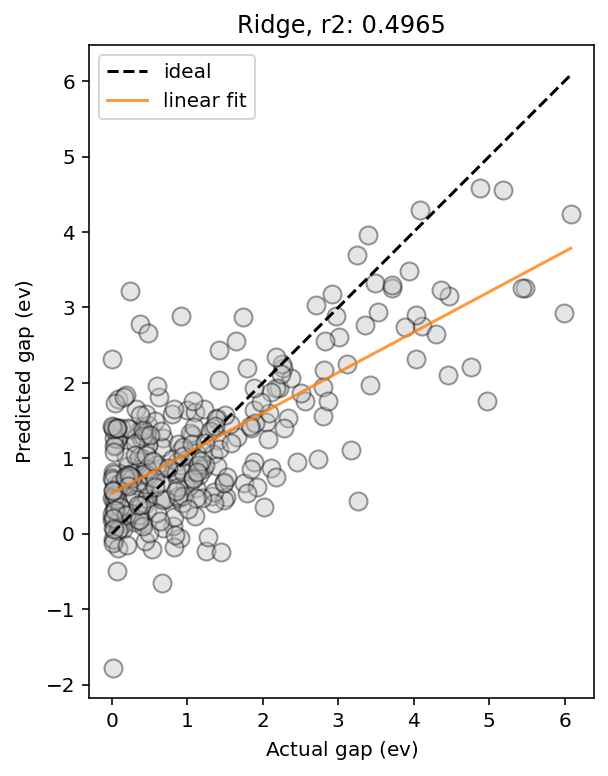

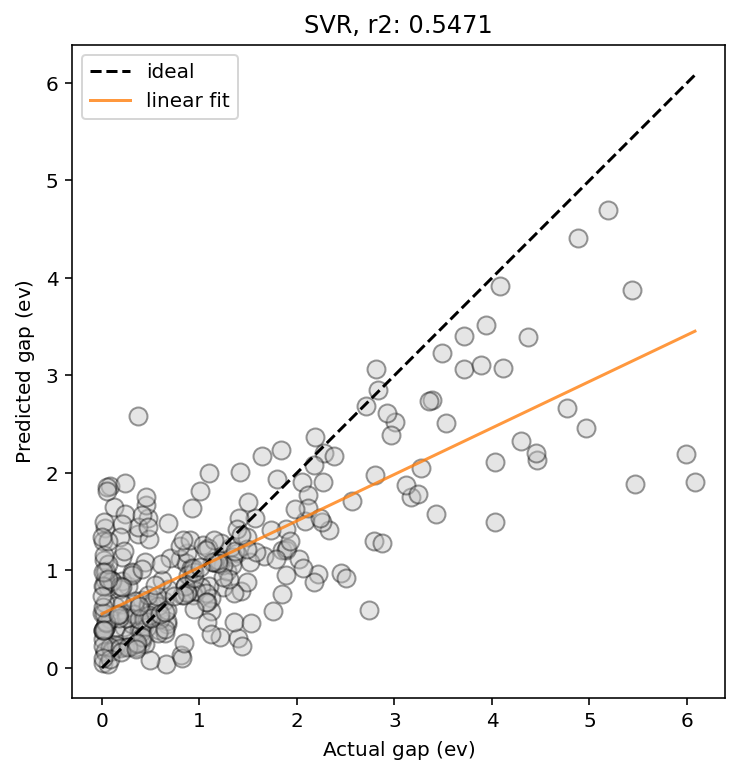

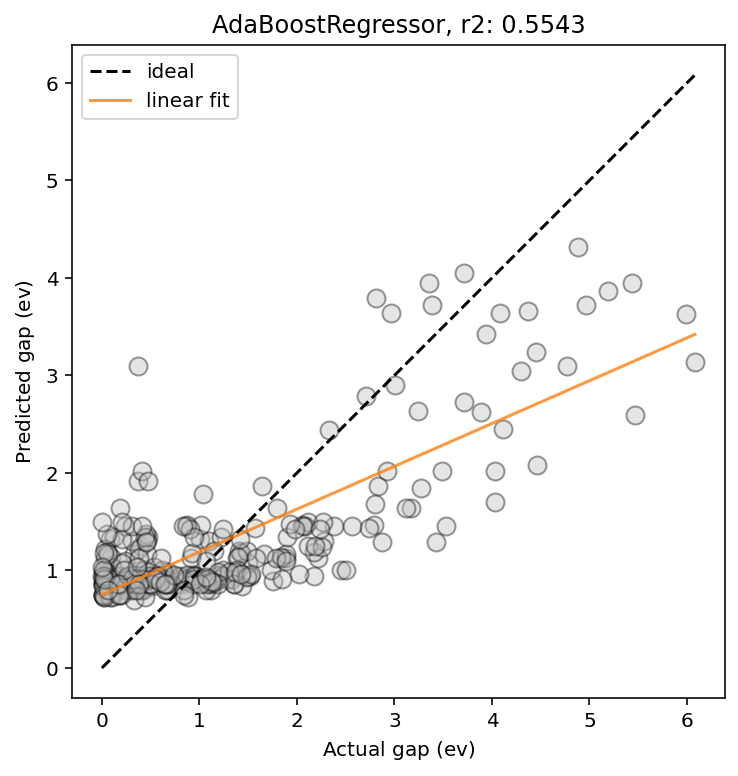

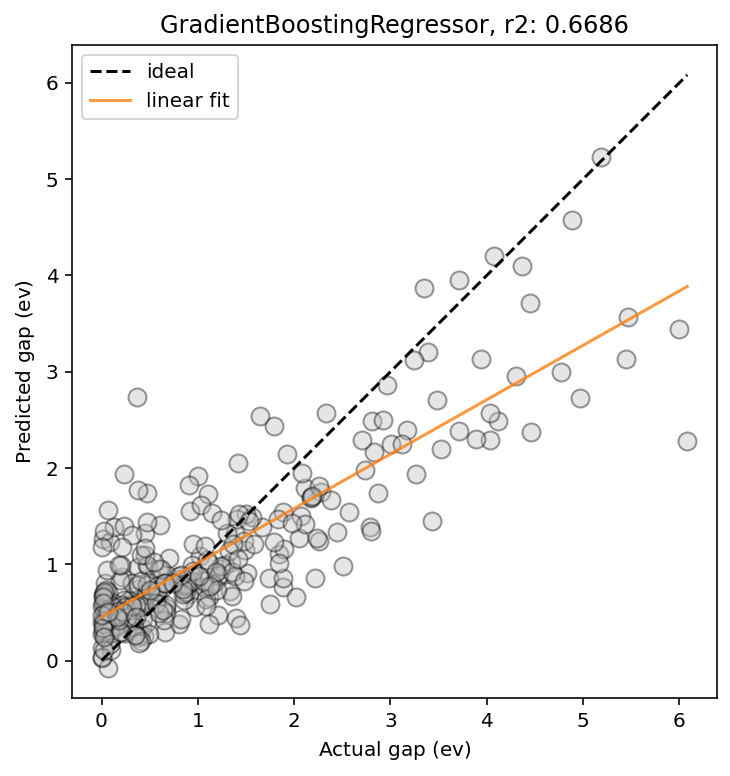

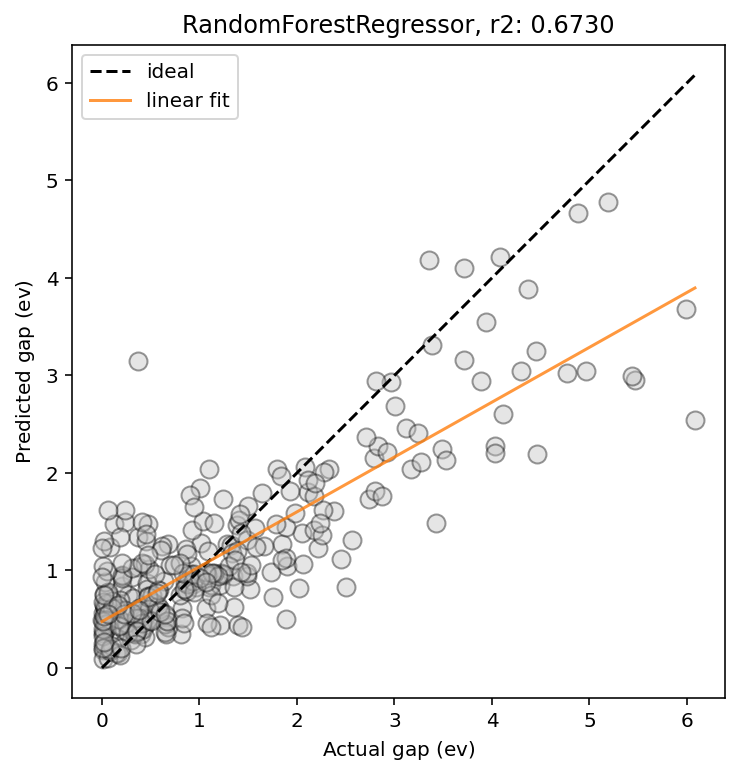

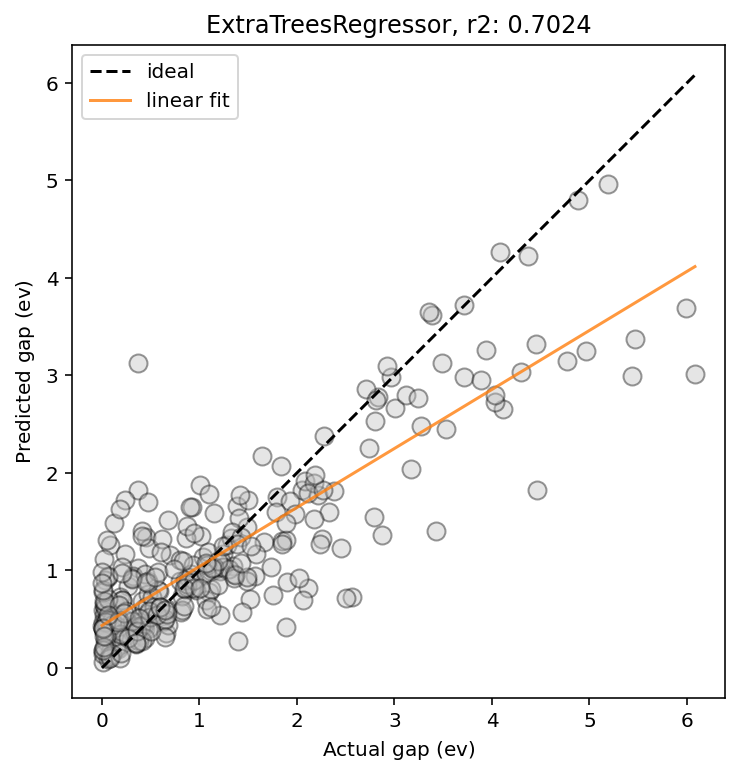

In [21]:
for row in range(df_classics.shape[0]):
    model_name = df_classics.iloc[row]['model_name']

    model = classic_models[model_name]
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{gap}$ (ev)')